In [1]:
import cudf
import cupy
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
import pickle
import gc

import pandas as pd
import numpy as np
from tqdm import tqdm
cudf.__version__

'21.10.01'

### Feature Engineering

In [2]:
def get_not_used():
    # cid is the label encode of customer_ID
    # row_id indicates the order of rows
    misscols= ['D_88','D_110','B_39','D_73','B_42','D_134','B_29','D_76','D_132','D_42','D_142','D_53']
    skew=['B_31', 'D_87']
    return ['row_id', 'customer_ID', 'target', 'cid', 'S_2','month']+skew+misscols[:-5]
    
def preprocess(df):
    df['row_id'] = cupy.arange(df.shape[0])
    not_used = get_not_used()
    cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    for col in df.columns:
        if col not in not_used+cat_cols:
            df[col] = df[col].round(2)

    df['S_2'] = cudf.to_datetime(df['S_2'])
    df['cid'], _ = df.customer_ID.factorize()
    df= df.sort_values(['customer_ID','S_2'])
    df['month']= df['S_2'].dt.day
    df['month'] =df.to_pandas().groupby('customer_ID')['month'].diff()
    
    important = ['P_2','B_1','B_4','D_39']
    num_cols = [col for col in df.columns if col not in cat_cols+not_used]+['month']
    nth_cols = [col for col in df.columns if col not in cat_cols+not_used][:30]+['customer_ID']
    
    dgs = add_stats_step(df, num_cols, cat_cols)
        
    # cudf merge changes row orders
    # restore the original row order by sorting row_id
    df= df.merge(df[nth_cols].groupby('customer_ID').nth(-2),on='customer_ID',how='left',suffixes=["_last_1","_last_2"])
    df = df.sort_values('row_id')
    df = df.drop(['row_id'],axis=1)
    return df, dgs

def add_stats_step(df, numcols, catcols):
    n = 50
    dgs = []
    for i in range(0,len(numcols),n):
        s = i
        e = min(s+n, len(numcols))
        dg = add_stats_one_shot_num(df, numcols[s:e])
        dgs.append(dg)
    for i in range(0,len(catcols),n):
        s = i
        e = min(s+n, len(catcols))
        dg = add_stats_one_shot_cat(df, catcols[s:e])
        dgs.append(dg)
    return dgs

def add_stats_one_shot_num(df, cols):
    stats = ['mean','max','min','std']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def add_stats_one_shot_cat(df, cols):
    stats = ['count', 'nunique']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def load_test_iter(path, chunks=4):
    
    test_rows = 11363762
    chunk_rows = test_rows // chunks
    
    test = cudf.read_parquet(f'{path}/test.parquet',
                             columns=['customer_ID','S_2'],
                             num_rows=test_rows)
    test = get_segment(test)
    start = 0
    while start < test.shape[0]:
        if start+chunk_rows < test.shape[0]:
            end = test['cus_count'].values[start+chunk_rows]
        else:
            end = test['cus_count'].values[-1]
        end = int(end)
        df = cudf.read_parquet(f'{path}/test.parquet',
                               num_rows = end-start, skiprows=start)
        start = end
        yield process_data(df)

def load_train(path):
    train = cudf.read_parquet(f'{path}/train.parquet')
    
    train = process_data(train)
    trainl = cudf.read_csv(f'../input/amex-default-prediction/train_labels.csv')
    train = train.merge(trainl, on='customer_ID', how='left')
    return train

def process_data(df):
    df,dgs = preprocess(df)
    df = df.drop_duplicates('customer_ID',keep='last')
    for dg in dgs:
        df = df.merge(dg, on='customer_ID', how='left')
#     diff_cols = [col for col in df.columns if col.endswith('_diff')]
#     df = df.drop(diff_cols,axis=1)
    return df


def get_segment(test):
    dg = test.groupby('customer_ID').agg({'S_2':'count'})
    dg.columns = ['cus_count']
    dg = dg.reset_index()
    dg['cid'],_ = dg['customer_ID'].factorize()
    dg = dg.sort_values('cid')
    dg['cus_count'] = dg['cus_count'].cumsum()
    
    test = test.merge(dg, on='customer_ID', how='left')
    test = test.sort_values(['cid','S_2'])
    assert test['cus_count'].values[-1] == test.shape[0]
    return test

### XGB/LGB Params and utility functions

In [3]:
def xgb_train(x, y, xt, yt):
    print("-----------xgb starts training-----------")
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    dtrain = xgb.DMatrix(data=x, label=y)
    dvalid = xgb.DMatrix(data=xt, label=yt)
    params = {
            'objective': 'binary:logistic', 
            'tree_method': 'gpu_hist', 
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.5,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda':70,
            'eta':0.03,
#             'scale_pos_weight': scale_pos_weight,
    }
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    bst = xgb.train(params, dtrain=dtrain,
                num_boost_round=2600,evals=watchlist,
                early_stopping_rounds=500, feval=xgb_amex, maximize=True,
                verbose_eval=100)
    print('best ntree_limit:', bst.best_ntree_limit)
    print('best score:', bst.best_score)
    return bst.predict(dtrain, iteration_range=(0,bst.best_ntree_limit)), bst.predict(dvalid, iteration_range=(0,bst.best_ntree_limit)), bst

In [4]:
def lgb_train(x, y, xt, yt):
    print("----------lgb starts training----------")
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    lgb_train = lgb.Dataset(x.to_pandas(), y.to_pandas())
    lgb_eval = lgb.Dataset(xt.to_pandas(), yt.to_pandas(), reference=lgb_train)

    params = {
        'boosting_type': 'dart',
        'n_estimators': 2000,
        'learning_rate': 0.05,
#         'min_child_samples': 2000,
        'reg_lambda':10,
        'feature_fraction':0.3,
        'bagging_fraction':0.3,
        'objective': 'binary',
    }
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=200,feval=amex_metric_mod_lgbm, 
                verbose_eval=100)


    print('best iterations:', gbm.best_iteration)
    print('best score:', gbm.best_score)
    return gbm.predict(x.to_pandas(), num_iteration =gbm.best_iteration),gbm.predict(xt.to_pandas(), num_iteration =gbm.best_iteration), gbm

In [5]:
def cat_train(x, y, xt, yt):
    print("-----------catboost starts training-----------")
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    cat_train = cat.Pool(x.to_pandas(), y.to_pandas())
    cat_eval = cat.Pool(xt.to_pandas(), yt.to_pandas())
    
    clf = CatBoostRegressor(iterations=3000, 
                             task_type='GPU',
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    clf.fit(cat_train, eval_set=cat_eval, verbose=100,early_stopping_rounds=500)
    return  clf.predict(cat_eval), clf

### Metrics

In [6]:
def lgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label()), True

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())

# Created by https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

# we still need the official metric since the faster version above is slightly off
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def amex_metric_mod_lgbm(y_pred: np.ndarray, data: lgb.Dataset):

    y_true = data.get_label()
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 'AMEX', 0.5 * (gini[1]/gini[0]+ top_four), True

### Load data and add feature

In [7]:
%%time

path = '../input/amex-data-integer-dtypes-parquet-format'
train = load_train(path)
# train2 = load_train(path,2)
train.shape

CPU times: user 1min 32s, sys: 10.4 s, total: 1min 42s
Wall time: 1min 59s


(458913, 921)

### Train Stacking Model in K-folds

In [8]:
%%time

not_used = get_not_used()
not_used = [i for i in not_used if i in train.columns]
msgs = {}
folds = 5
score = 0

#set diff cols if u wanna try different features on xgb & lgbm
diff_cols= [col for col in train.columns if col.endswith('_max') or col.endswith('_min') or col.endswith('_mean') or col.endswith('_std') or col.endswith('_count')]


for i in range(folds):
    print(f"==============Folds {i}===============")
    mask = train['cid']%folds == i
    tr,va = train[~mask], train[mask]

    x, y = tr.drop(not_used, axis=1), tr['target']
    xt, yt = va.drop(not_used, axis=1), va['target']
    
    xp, yp, bst = xgb_train(x, y, xt, yt)
    bst.save_model(f'xgb_{i}.json')

    x = tr.drop(not_used+diff_cols, axis=1)
    xt = va.drop(not_used+diff_cols, axis=1)
    
    xp2,yp2,gbm = lgb_train(x, y, xt, yt)
    gbm.save_model(f'lgb_{i}.json')
    
    yp3,cats = cat_train(x, y, xt, yt)
    cats.save_model(f'cat_{i}.json')

    X_estimator = np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1)
    final_estimator = LogisticRegression(penalty="l1",solver="saga",C=0.001,max_iter=1000,class_weight="balanced")
    final_estimator.fit(X_estimator, yt.to_pandas())
    with open(f'lr_{i}.pkl','wb') as f:
        pickle.dump(final_estimator, f)
    preds=final_estimator.predict_proba(np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1))[:,1]

    amex_score = amex_metric(pd.DataFrame({'target':yt.values.get()}), 
                                    pd.DataFrame({'prediction':preds}))
    msg = f"Fold {i} amex {amex_score:.4f}"
    print(msg)
    score += amex_score
score /= folds
print(f"Average amex score: {score:.4f}")

==============Folds 0===============
-----------xgb starts training-----------
# of features: 907


/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67373	train-amex:0.70346	eval-logloss:0.67382	eval-amex:0.69732
[100]	train-logloss:0.24267	train-amex:0.78031	eval-logloss:0.24787	eval-amex:0.76648
[200]	train-logloss:0.21747	train-amex:0.79804	eval-logloss:0.22691	eval-amex:0.77798
[300]	train-logloss:0.20865	train-amex:0.81019	eval-logloss:0.22226	eval-amex:0.78238
[400]	train-logloss:0.20308	train-amex:0.81885	eval-logloss:0.22024	eval-amex:0.78614
[500]	train-logloss:0.19868	train-amex:0.82573	eval-logloss:0.21900	eval-amex:0.78804
[600]	train-logloss:0.19482	train-amex:0.83252	eval-logloss:0.21822	eval-amex:0.78927
[700]	train-logloss:0.19121	train-amex:0.83860	eval-logloss:0.21771	eval-amex:0.79058
[800]	train-logloss:0.18780	train-amex:0.84489	eval-logloss:0.21723	eval-amex:0.79105
[900]	train-logloss:0.18458	train-amex:0.85044	eval-logloss:0.21692	eval-amex:0.79137
[1000]	train-logloss:0.18164	train-amex:0.85557	eval-logloss:0.21669	eval-amex:0.79165
[1100]	train-logloss:0.17882	train-amex:0.86066	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95258, number of negative: 271872
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.331123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20518
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259467 -> initscore=-1.048742
[LightGBM] [Info] Start training from score -1.048742


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.276089	training's AMEX: 0.765128	valid_1's binary_logloss: 0.277171	valid_1's AMEX: 0.758878
[200]	training's binary_logloss: 0.247695	training's AMEX: 0.772774	valid_1's binary_logloss: 0.249764	valid_1's AMEX: 0.764155
[300]	training's binary_logloss: 0.232943	training's AMEX: 0.780115	valid_1's binary_logloss: 0.236167	valid_1's AMEX: 0.771302
[400]	training's binary_logloss: 0.225743	training's AMEX: 0.786259	valid_1's binary_logloss: 0.230015	valid_1's AMEX: 0.776478
[500]	training's binary_logloss: 0.220984	training's AMEX: 0.79135	valid_1's binary_logloss: 0.226386	valid_1's AMEX: 0.780527
[600]	training's binary_logloss: 0.219805	training's AMEX: 0.794485	valid_1's binary_logloss: 0.225798	valid_1's AMEX: 0.781235
[700]	training's binary_logloss: 0.21714	training's AMEX: 0.797483	valid_1's binary_logloss: 0.224091	valid_1's AMEX: 0.783637
[800]	training's binary_logloss: 0.215664	training's AMEX: 0.800534	valid_1's binary_logloss: 0.223321	val

Learning rate set to 0.085928
0:	learn: 0.4187260	test: 0.4173723	best: 0.4173723 (0)	total: 16.7ms	remaining: 49.9s
100:	learn: 0.2697596	test: 0.2709840	best: 0.2709840 (100)	total: 1.26s	remaining: 36.3s
200:	learn: 0.2656019	test: 0.2680950	best: 0.2680950 (200)	total: 2.77s	remaining: 38.6s
300:	learn: 0.2631384	test: 0.2668591	best: 0.2668591 (300)	total: 3.77s	remaining: 33.8s
400:	learn: 0.2612595	test: 0.2661070	best: 0.2661070 (400)	total: 4.74s	remaining: 30.7s
500:	learn: 0.2596715	test: 0.2656074	best: 0.2656074 (500)	total: 5.72s	remaining: 28.6s
600:	learn: 0.2582714	test: 0.2652459	best: 0.2652459 (600)	total: 7.05s	remaining: 28.1s
700:	learn: 0.2569877	test: 0.2650440	best: 0.2650383 (695)	total: 8.02s	remaining: 26.3s
800:	learn: 0.2558190	test: 0.2648753	best: 0.2648744 (797)	total: 8.97s	remaining: 24.6s
900:	learn: 0.2546921	test: 0.2647190	best: 0.2647190 (900)	total: 9.97s	remaining: 23.2s
1000:	learn: 0.2536383	test: 0.2646167	best: 0.2646153 (999)	total: 10.9s

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67372	train-amex:0.70766	eval-logloss:0.67380	eval-amex:0.70244
[100]	train-logloss:0.24233	train-amex:0.77927	eval-logloss:0.24875	eval-amex:0.76812
[200]	train-logloss:0.21720	train-amex:0.79656	eval-logloss:0.22797	eval-amex:0.77969
[300]	train-logloss:0.20829	train-amex:0.80978	eval-logloss:0.22316	eval-amex:0.78471
[400]	train-logloss:0.20267	train-amex:0.81841	eval-logloss:0.22099	eval-amex:0.78714
[500]	train-logloss:0.19797	train-amex:0.82633	eval-logloss:0.21971	eval-amex:0.78841
[600]	train-logloss:0.19391	train-amex:0.83294	eval-logloss:0.21890	eval-amex:0.78999
[700]	train-logloss:0.19045	train-amex:0.83885	eval-logloss:0.21831	eval-amex:0.79089
[800]	train-logloss:0.18695	train-amex:0.84505	eval-logloss:0.21788	eval-amex:0.79069
[900]	train-logloss:0.18380	train-amex:0.85070	eval-logloss:0.21759	eval-amex:0.79092
[1000]	train-logloss:0.18069	train-amex:0.85651	eval-logloss:0.21732	eval-amex:0.79130
[1100]	train-logloss:0.17795	train-amex:0.86173	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95167, number of negative: 271963
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.409954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20541
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259219 -> initscore=-1.050033
[LightGBM] [Info] Start training from score -1.050033


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.275822	training's AMEX: 0.765016	valid_1's binary_logloss: 0.277862	valid_1's AMEX: 0.759197
[200]	training's binary_logloss: 0.247179	training's AMEX: 0.772472	valid_1's binary_logloss: 0.250421	valid_1's AMEX: 0.765468
[300]	training's binary_logloss: 0.232441	training's AMEX: 0.781224	valid_1's binary_logloss: 0.237	valid_1's AMEX: 0.772248
[400]	training's binary_logloss: 0.225429	training's AMEX: 0.78637	valid_1's binary_logloss: 0.231299	valid_1's AMEX: 0.773627
[500]	training's binary_logloss: 0.220613	training's AMEX: 0.792481	valid_1's binary_logloss: 0.227708	valid_1's AMEX: 0.777759
[600]	training's binary_logloss: 0.219423	training's AMEX: 0.795288	valid_1's binary_logloss: 0.227015	valid_1's AMEX: 0.778648
[700]	training's binary_logloss: 0.216818	training's AMEX: 0.798334	valid_1's binary_logloss: 0.225419	valid_1's AMEX: 0.779841
[800]	training's binary_logloss: 0.215375	training's AMEX: 0.801019	valid_1's binary_logloss: 0.224637	valid

Learning rate set to 0.085928
0:	learn: 0.4186396	test: 0.4179414	best: 0.4179414 (0)	total: 12ms	remaining: 36s
100:	learn: 0.2694863	test: 0.2711811	best: 0.2711811 (100)	total: 1.02s	remaining: 29.2s
200:	learn: 0.2654826	test: 0.2682030	best: 0.2682030 (200)	total: 2.01s	remaining: 28s
300:	learn: 0.2630438	test: 0.2669058	best: 0.2669058 (300)	total: 3s	remaining: 26.9s
400:	learn: 0.2612308	test: 0.2662293	best: 0.2662293 (400)	total: 3.97s	remaining: 25.7s
500:	learn: 0.2597057	test: 0.2657089	best: 0.2657089 (500)	total: 4.95s	remaining: 24.7s
600:	learn: 0.2583170	test: 0.2653771	best: 0.2653771 (600)	total: 6.39s	remaining: 25.5s
700:	learn: 0.2570314	test: 0.2650715	best: 0.2650711 (699)	total: 7.36s	remaining: 24.1s
800:	learn: 0.2557712	test: 0.2648584	best: 0.2648552 (799)	total: 8.38s	remaining: 23s
900:	learn: 0.2546216	test: 0.2646610	best: 0.2646610 (900)	total: 9.35s	remaining: 21.8s
1000:	learn: 0.2535577	test: 0.2645543	best: 0.2645543 (1000)	total: 10.3s	remaining

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67374	train-amex:0.70368	eval-logloss:0.67385	eval-amex:0.69561
[100]	train-logloss:0.24232	train-amex:0.78088	eval-logloss:0.24909	eval-amex:0.76811
[200]	train-logloss:0.21739	train-amex:0.79820	eval-logloss:0.22782	eval-amex:0.78025
[300]	train-logloss:0.20866	train-amex:0.81080	eval-logloss:0.22273	eval-amex:0.78590
[400]	train-logloss:0.20293	train-amex:0.81976	eval-logloss:0.22027	eval-amex:0.78984
[500]	train-logloss:0.19855	train-amex:0.82688	eval-logloss:0.21897	eval-amex:0.79134
[600]	train-logloss:0.19466	train-amex:0.83363	eval-logloss:0.21810	eval-amex:0.79235
[700]	train-logloss:0.19110	train-amex:0.83992	eval-logloss:0.21749	eval-amex:0.79307
[800]	train-logloss:0.18774	train-amex:0.84562	eval-logloss:0.21705	eval-amex:0.79325
[900]	train-logloss:0.18481	train-amex:0.85046	eval-logloss:0.21667	eval-amex:0.79409
[1000]	train-logloss:0.18175	train-amex:0.85572	eval-logloss:0.21637	eval-amex:0.79428
[1100]	train-logloss:0.17879	train-amex:0.86114	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 94985, number of negative: 272145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.307784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20523
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258723 -> initscore=-1.052616
[LightGBM] [Info] Start training from score -1.052616


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.275793	training's AMEX: 0.76508	valid_1's binary_logloss: 0.2783	valid_1's AMEX: 0.759922
[200]	training's binary_logloss: 0.247284	training's AMEX: 0.772684	valid_1's binary_logloss: 0.25053	valid_1's AMEX: 0.767245
[300]	training's binary_logloss: 0.232585	training's AMEX: 0.780512	valid_1's binary_logloss: 0.23682	valid_1's AMEX: 0.7741
[400]	training's binary_logloss: 0.225663	training's AMEX: 0.786168	valid_1's binary_logloss: 0.230828	valid_1's AMEX: 0.777801
[500]	training's binary_logloss: 0.220837	training's AMEX: 0.791824	valid_1's binary_logloss: 0.227117	valid_1's AMEX: 0.781216
[600]	training's binary_logloss: 0.219639	training's AMEX: 0.794714	valid_1's binary_logloss: 0.226438	valid_1's AMEX: 0.782864
[700]	training's binary_logloss: 0.217024	training's AMEX: 0.798083	valid_1's binary_logloss: 0.224646	valid_1's AMEX: 0.785535
[800]	training's binary_logloss: 0.215609	training's AMEX: 0.800346	valid_1's binary_logloss: 0.22386	valid_1's

Learning rate set to 0.085928
0:	learn: 0.4183554	test: 0.4190070	best: 0.4190070 (0)	total: 12.2ms	remaining: 36.4s
100:	learn: 0.2697065	test: 0.2707711	best: 0.2707711 (100)	total: 1.04s	remaining: 29.8s
200:	learn: 0.2656718	test: 0.2677152	best: 0.2677152 (200)	total: 2.02s	remaining: 28.1s
300:	learn: 0.2632112	test: 0.2663770	best: 0.2663770 (300)	total: 3.02s	remaining: 27.1s
400:	learn: 0.2613520	test: 0.2656679	best: 0.2656679 (400)	total: 4.35s	remaining: 28.2s
500:	learn: 0.2597669	test: 0.2651746	best: 0.2651746 (500)	total: 5.32s	remaining: 26.5s
600:	learn: 0.2583996	test: 0.2647726	best: 0.2647726 (600)	total: 6.3s	remaining: 25.1s
700:	learn: 0.2570582	test: 0.2644900	best: 0.2644900 (700)	total: 7.27s	remaining: 23.9s
800:	learn: 0.2558881	test: 0.2642805	best: 0.2642783 (799)	total: 8.27s	remaining: 22.7s
900:	learn: 0.2547950	test: 0.2641089	best: 0.2641075 (898)	total: 9.24s	remaining: 21.5s
1000:	learn: 0.2536729	test: 0.2639498	best: 0.2639496 (999)	total: 10.2s	

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67375	train-amex:0.70630	eval-logloss:0.67381	eval-amex:0.70538
[100]	train-logloss:0.24255	train-amex:0.77995	eval-logloss:0.24789	eval-amex:0.77071
[200]	train-logloss:0.21752	train-amex:0.79708	eval-logloss:0.22672	eval-amex:0.78195
[300]	train-logloss:0.20859	train-amex:0.81042	eval-logloss:0.22170	eval-amex:0.78692
[400]	train-logloss:0.20313	train-amex:0.81864	eval-logloss:0.21941	eval-amex:0.79122
[500]	train-logloss:0.19849	train-amex:0.82632	eval-logloss:0.21802	eval-amex:0.79283
[600]	train-logloss:0.19456	train-amex:0.83297	eval-logloss:0.21712	eval-amex:0.79433
[700]	train-logloss:0.19110	train-amex:0.83913	eval-logloss:0.21653	eval-amex:0.79443
[800]	train-logloss:0.18779	train-amex:0.84490	eval-logloss:0.21607	eval-amex:0.79529
[900]	train-logloss:0.18474	train-amex:0.85014	eval-logloss:0.21572	eval-amex:0.79570
[1000]	train-logloss:0.18168	train-amex:0.85597	eval-logloss:0.21542	eval-amex:0.79562
[1100]	train-logloss:0.17877	train-amex:0.86143	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 94856, number of negative: 272275
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20527
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258371 -> initscore=-1.054453
[LightGBM] [Info] Start training from score -1.054453


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.276052	training's AMEX: 0.764295	valid_1's binary_logloss: 0.277452	valid_1's AMEX: 0.761975
[200]	training's binary_logloss: 0.247457	training's AMEX: 0.771813	valid_1's binary_logloss: 0.249656	valid_1's AMEX: 0.76658
[300]	training's binary_logloss: 0.232755	training's AMEX: 0.780426	valid_1's binary_logloss: 0.235905	valid_1's AMEX: 0.772719
[400]	training's binary_logloss: 0.225846	training's AMEX: 0.785258	valid_1's binary_logloss: 0.229896	valid_1's AMEX: 0.778236
[500]	training's binary_logloss: 0.220987	training's AMEX: 0.791533	valid_1's binary_logloss: 0.226271	valid_1's AMEX: 0.781347
[600]	training's binary_logloss: 0.21979	training's AMEX: 0.79461	valid_1's binary_logloss: 0.225602	valid_1's AMEX: 0.783752
[700]	training's binary_logloss: 0.217173	training's AMEX: 0.797153	valid_1's binary_logloss: 0.223921	valid_1's AMEX: 0.784857
[800]	training's binary_logloss: 0.215741	training's AMEX: 0.80008	valid_1's binary_logloss: 0.223216	valid

Learning rate set to 0.085928
0:	learn: 0.4182180	test: 0.4196144	best: 0.4196144 (0)	total: 12.5ms	remaining: 37.4s
100:	learn: 0.2697448	test: 0.2705284	best: 0.2705284 (100)	total: 1.03s	remaining: 29.7s
200:	learn: 0.2656892	test: 0.2674263	best: 0.2674263 (200)	total: 2.43s	remaining: 33.8s
300:	learn: 0.2632441	test: 0.2661250	best: 0.2661250 (300)	total: 3.43s	remaining: 30.7s
400:	learn: 0.2614025	test: 0.2653698	best: 0.2653698 (400)	total: 4.41s	remaining: 28.6s
500:	learn: 0.2598391	test: 0.2648505	best: 0.2648504 (499)	total: 5.39s	remaining: 26.9s
600:	learn: 0.2584466	test: 0.2644954	best: 0.2644954 (600)	total: 6.36s	remaining: 25.4s
700:	learn: 0.2571341	test: 0.2642304	best: 0.2642304 (700)	total: 7.35s	remaining: 24.1s
800:	learn: 0.2560072	test: 0.2640645	best: 0.2640593 (799)	total: 8.31s	remaining: 22.8s
900:	learn: 0.2549267	test: 0.2639483	best: 0.2639483 (900)	total: 9.27s	remaining: 21.6s
1000:	learn: 0.2538473	test: 0.2638214	best: 0.2638214 (1000)	total: 10.2

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67373	train-amex:0.70590	eval-logloss:0.67381	eval-amex:0.69788
[100]	train-logloss:0.24240	train-amex:0.78096	eval-logloss:0.24863	eval-amex:0.76559
[200]	train-logloss:0.21727	train-amex:0.79827	eval-logloss:0.22800	eval-amex:0.78003
[300]	train-logloss:0.20849	train-amex:0.81103	eval-logloss:0.22337	eval-amex:0.78579
[400]	train-logloss:0.20258	train-amex:0.82064	eval-logloss:0.22120	eval-amex:0.78961
[500]	train-logloss:0.19815	train-amex:0.82773	eval-logloss:0.21998	eval-amex:0.79097
[600]	train-logloss:0.19419	train-amex:0.83442	eval-logloss:0.21920	eval-amex:0.79154
[700]	train-logloss:0.19062	train-amex:0.84095	eval-logloss:0.21864	eval-amex:0.79183
[800]	train-logloss:0.18711	train-amex:0.84681	eval-logloss:0.21816	eval-amex:0.79241
[900]	train-logloss:0.18403	train-amex:0.85225	eval-logloss:0.21790	eval-amex:0.79295
[1000]	train-logloss:0.18082	train-amex:0.85752	eval-logloss:0.21766	eval-amex:0.79285
[1100]	train-logloss:0.17777	train-amex:0.86250	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95046, number of negative: 272085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.300046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20549
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258889 -> initscore=-1.051754
[LightGBM] [Info] Start training from score -1.051754


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.276022	training's AMEX: 0.764806	valid_1's binary_logloss: 0.277935	valid_1's AMEX: 0.757028
[200]	training's binary_logloss: 0.247426	training's AMEX: 0.771834	valid_1's binary_logloss: 0.250219	valid_1's AMEX: 0.76516
[300]	training's binary_logloss: 0.232722	training's AMEX: 0.779762	valid_1's binary_logloss: 0.236574	valid_1's AMEX: 0.771915
[400]	training's binary_logloss: 0.225747	training's AMEX: 0.785666	valid_1's binary_logloss: 0.230661	valid_1's AMEX: 0.775505
[500]	training's binary_logloss: 0.220851	training's AMEX: 0.791499	valid_1's binary_logloss: 0.226977	valid_1's AMEX: 0.780838
[600]	training's binary_logloss: 0.219669	training's AMEX: 0.794761	valid_1's binary_logloss: 0.226317	valid_1's AMEX: 0.782899
[700]	training's binary_logloss: 0.217022	training's AMEX: 0.797676	valid_1's binary_logloss: 0.224652	valid_1's AMEX: 0.78412
[800]	training's binary_logloss: 0.21556	training's AMEX: 0.800225	valid_1's binary_logloss: 0.223918	vali

Learning rate set to 0.085928
0:	learn: 0.4184372	test: 0.4185873	best: 0.4185873 (0)	total: 12.1ms	remaining: 36.2s
100:	learn: 0.2695355	test: 0.2708302	best: 0.2708302 (100)	total: 1.03s	remaining: 29.6s
200:	learn: 0.2655673	test: 0.2678255	best: 0.2678255 (200)	total: 2.45s	remaining: 34.1s
300:	learn: 0.2631559	test: 0.2664830	best: 0.2664830 (300)	total: 3.48s	remaining: 31.2s
400:	learn: 0.2613011	test: 0.2657718	best: 0.2657718 (400)	total: 4.46s	remaining: 28.9s
500:	learn: 0.2597396	test: 0.2653356	best: 0.2653356 (500)	total: 5.44s	remaining: 27.1s
600:	learn: 0.2583743	test: 0.2650292	best: 0.2650285 (598)	total: 6.41s	remaining: 25.6s
700:	learn: 0.2570838	test: 0.2647779	best: 0.2647779 (700)	total: 7.38s	remaining: 24.2s
800:	learn: 0.2558439	test: 0.2645663	best: 0.2645663 (800)	total: 8.37s	remaining: 23s
900:	learn: 0.2547186	test: 0.2644271	best: 0.2644260 (899)	total: 9.36s	remaining: 21.8s
1000:	learn: 0.2536835	test: 0.2643403	best: 0.2643386 (999)	total: 10.3s	r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

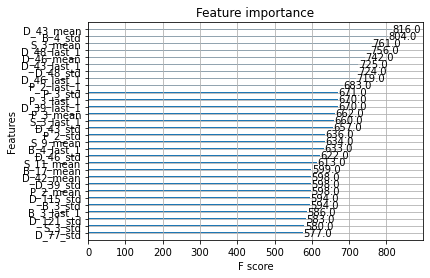

In [9]:
from xgboost import plot_importance
plot_importance(bst,max_num_features=30)


In [10]:
del train
del tr,va
gc.collect()

46

### Inference

In [11]:
%%time
cids = []
yps = []
# set chunks 
chunks = 10


for df in tqdm(load_test_iter(path,chunks),total=chunks):
    cids.append(df['customer_ID'])
    not_used = [i for i in not_used if i in df.columns]

    preds=0
    for i in range(folds):
        bst = xgb.Booster()
        bst.load_model(f'xgb_{i}.json')
        dx = xgb.DMatrix(df.drop(not_used, axis=1))
        
        gbm = lgb.Booster(model_file=f'lgb_{i}.json')
        dx2 = df.drop(not_used+diff_cols, axis=1).to_pandas()
        
        with open(f'lr_{i}.pkl','rb') as f:
            Lr= pickle.load(f)
        
        yp = bst.predict(dx, iteration_range=(0,bst.best_ntree_limit))
        yp2 = gbm.predict(dx2, num_iteration =gbm.best_iteration)
        preds+=final_estimator.predict_proba(np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1))[:,1]
        
    yps.append(preds/folds)
    
df = cudf.DataFrame()
df['customer_ID'] = cudf.concat(cids)
df['prediction'] = np.concatenate(yps)
df.head()

100%|██████████| 10/10 [26:00<00:00, 156.06s/it]

CPU times: user 42min 31s, sys: 46.8 s, total: 43min 18s
Wall time: 26min


,customer_ID,prediction
0,0038e9461e0efc946191aafbced4d56c0325e1112a47ed...,0.604045
1,0039363e29198d1c54be05d981f651164f1345acf05cf4...,0.144247
2,00394eb5d72fa69a3a135b1d40290c8fd7d8ed675e235d...,0.093850
3,0039cb1fd301905922ba9c221cbab044a7f119d46c1320...,0.973244
4,0039eacafa48ef4b5817a9936e9d4ff99932079f5b1d40...,0.093263


In [12]:
df.to_csv('submission.csv',index=False)